# Indoor Location & Navigation - Basic EDA - Traces and Features Visualization

In [1]:
import os
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Defined tools

Here is some defined visualization and data loading tools what will be used later. Feel free to use it if you like =)

Trace parsing script (function `load_trace_as_dataframe`) taken from [this post](https://www.kaggle.com/c/indoor-location-navigation/discussion/215381).  
Thanks [Tolga Dincer](https://www.kaggle.com/tolgadincer) for this =)

In [2]:
def load_trace_as_dataframe(filepath):
    # Returns trace dataframe sorted by timestamp
    
    names = ['time', 'type'] + [f'col_{i}' for i in range(1, 9)]
    
    trace_df = pd.read_csv(
        filepath, sep='\t', comment='#', header=None, names=names
    )
    
    trace_df.sort_values(by='time', inplace=True)
    trace_df.reset_index(drop=True, inplace=True)
    return trace_df


def extract_feature_df(trace_df, 
                       feature_name, 
                       col_names=('x', 'y', 'z', 'accuracy')):
    
    ''' 
    Extracts feature dataframe from trace dataframe by feature name.
    
    Suitable for features: 
    ----------------------
        TYPE_WAYPOINT, if set col_names=('x', 'y'),
        TYPE_ACCELEROMETER,
        TYPE_GYROSCOPE,
        TYPE_MAGNETIC_FIELD, 
        TYPE_ROTATION_VECTOR,
        
        TYPE_ACCELEROMETER_UNCALIBRATED, 
                    if set col_names=('x', 'y', 'z', 'x_2', 'y_2', 'z_2', 'accuracy'),
                    
        TYPE_GYROSCOPE_UNCALIBRATED, 
                    if set col_names=('x', 'y', 'z', 'x_2', 'y_2', 'z_2', 'accuracy'),
                    
        TYPE_MAGNETIC_FIELD_UNCALIBRATED, 
                    if set col_names=('x', 'y', 'z', 'x_2', 'y_2', 'z_2', 'accuracy')
    '''
    
    feature_df = trace_df[trace_df['type'] == feature_name].copy()
    for i, col in enumerate(col_names, start=1):
        feature_df[col] = feature_df[f'col_{i}'].astype('float64')
        
    feature_df.drop(columns=[f'col_{i}' for i in range(1, 9)], inplace=True)
    feature_df.drop(columns=['type'], inplace=True)
    feature_df.reset_index(drop=True, inplace=True)
    
    return feature_df


def load_points(filepath):
    # Takes the path to the trace file.
    # Returns pandas dataframe which consists of device locations 
    # as x and y coordinates (values from TYPE_WAYPOINT) and their timestamps.
    
    trace_df = load_trace_as_dataframe(filepath)
    points_df = extract_feature_df(
        trace_df, 'TYPE_WAYPOINT', col_names=('x', 'y')
    )
    
    return points_df


def visualize_many_traces_on_the_map(traces_dataframes, map_image, width, height, 
                                     traces_filenames=None, 
                                     figsize=None):
    
    
    '''
    Draws traces on the floor map.
    
    Parameters
    ----------
        traces_dataframes: list of pandas DataFrames
            Each DataFrame should consist of device locations as x and y 
            coordinates and their timestamps.

        map_image : numpy.array
            Image of floor map.

        width : float,
            Width of floor. Should be taken from floor_info.json

        height : float, 
            Height of floor. Should be taken from floor_info.json

        traces_filenames : list of strings, optional, default: None
            List of filenames. Used to display the legend. 
            There will be no legend if you pass traces_filenames=None

        figsize : (float, float), optional, default: None
            Size of the result image in terms of matplotlib.
    
    '''
    
    fig = plt.figure(figsize=figsize)
    ax = plt.subplot(111)

    plt.imshow(map_image, extent=[0, width, 0, height])

    if traces_filenames:
        
        for filename, points in zip(traces_filenames, traces_dataframes):
            plt.scatter(points['x'], points['y'], label=filename)
            plt.plot(points['x'], points['y'])
            
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        for points in traces_dataframes:
            plt.scatter(points['x'], points['y'])
            plt.plot(points['x'], points['y'])


    plt.show()

    
def visualize_single_trace_on_the_map(points_df, map_image, width, height, 
                                      scaling_coef=0.3, figsize=None):
    
    '''
    Draws single trace on the floor map.
    
    Parameters
    ----------
        points_df: pandas DataFrame
            Should consist of device locations as x and y 
            coordinates and their timestamps.

        map_image : numpy.array
            Image of floor map.

        width : float,
            Width of floor. Should be taken from floor_info.json

        height : float, 
            Height of floor. Should be taken from floor_info.json

        scaling_coef : float
            Scaling Coefficient. 

        figsize : (float, float), optional, default: None
            Size of the result image in terms of matplotlib.
    
    '''
    
    fig = plt.figure(figsize=figsize)
    ax = plt.subplot(111)

    plt.imshow(map_image, extent=[0, width, 0, height])
    plt.plot(points_df['x'], points_df['y'], linewidth=5, linestyle='-', color='blue')

    for i in range(len(points_df)):
        ax.text(
            points_df.loc[i, 'x'], points_df.loc[i, 'y'], i, 
            ha="center", size=15, 
            bbox=dict(boxstyle="circle, pad=0.3", 
                      fc="cyan", lw=2)
        )
 
    x_min, x_max = points_df['x'].min(), points_df['x'].max()
    y_min, y_max = points_df['y'].min(), points_df['y'].max()

    ax.set_xlim(x_min - scaling_coef*(x_max - x_min), x_max + scaling_coef*(x_max - x_min))
    ax.set_ylim(y_min - scaling_coef*(y_max - y_min), y_max + scaling_coef*(y_max - y_min))

    plt.show()

    
def plot_trace_features(feature_df, timestamps=None, figsize=None):
    
    '''
    Plots the trace features.
    
    Parameters
    ----------
        feature_df : pandas DataFrame
            Can be exctracted from trace dataframe 
            using extract_feature_df function.
        
        timestamps : array-like, optional, default: None
            Array of timestamps. 
            Used to mark timestamps on the chart in the form of vertical lines.
            Pass timestamps=None if you don't want to use this feature.

        figsize : (float, float), optional, default: None
            Size of the result image in terms of matplotlib.
    
    Suitable for features: 
    ----------------------
        TYPE_ACCELEROMETER 
        TYPE_GYROSCOPE 
        TYPE_MAGNETIC_FIELD 
        TYPE_ROTATION_VECTOR 
        TYPE_ACCELEROMETER_UNCALIBRATED 
        TYPE_GYROSCOPE_UNCALIBRATED 
        TYPE_MAGNETIC_FIELD_UNCALIBRATED
    '''
    
    fig = plt.figure(figsize=figsize)
    ax = plt.subplot(111)

    for col in ['x', 'y', 'z']:
        plt.plot(feature_df['time'], feature_df[col], label=col)


    if points_df is not None:
        xmin, xmax, ymin, ymax = plt.axis()

        for i, timestamp in enumerate(timestamps):
            plt.axvline(x=timestamp, c='k', ls='--')

            ax.text(
            timestamp, ymax, i, 
            ha="center", size=15, 
            bbox=dict(boxstyle="circle, pad=0.3", 
                      fc="white", lw=2)
            )
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

# Let's take a look into data directory.

In [3]:
data_path = '/kaggle/input/indoor-location-navigation'
os.listdir(data_path)

['metadata', 'sample_submission.csv', 'test', 'train']

* **train** directory contains sites (shopping malls) directories that consists of floor direcories. And each floor directory contains txt files, that have information about paths (smarthones).

* **metedata** directory contains floor map, its size and geo inforamation for each site and each floor.

In this competition we should predict smartphone location: floor number and x, y coordinates (TYPE_WAYPOINT). 


In [4]:
floor = '5a0546857ecc773753327266/F1'
floor_metadata_dir = os.path.join(data_path, 'metadata', floor)
floor_train_dir = os.path.join(data_path, 'train', floor)

os.listdir(floor_metadata_dir)

['geojson_map.json', 'floor_info.json', 'floor_image.png']

In [5]:
# os.listdir(os.path.join(data_path, 'train'))[:10]

In [6]:
# os.listdir(floor_train_dir)[:5]

# Loading coordinates of paths points

In [7]:
paths = []
for filename in os.listdir(floor_train_dir):
    if '.txt' not in filename:
        continue
    points = load_points(os.path.join(floor_train_dir, filename))
    paths.append((filename, points))

paths = sorted(paths, key=lambda path: len(path[1]), reverse=True)
paths = paths[:20]


traces_dataframes = [trace for filename, trace in paths]
traces_filenames = [filename for filename, trace in paths]

# Loading floor map and its size

In [8]:
MAP_IMAGE = plt.imread(
    os.path.join(floor_metadata_dir, 'floor_image.png')
)

with open(os.path.join(floor_metadata_dir, 'floor_info.json')) as f:
    content = f.read()
    floor_info = json.loads(content)

MAP_HEIGHT = float(floor_info['map_info']['height'])
MAP_WIDTH = float(floor_info['map_info']['width'])
    
floor_info

{'map_info': {'height': 152.3075447409275, 'width': 122.40020010253855}}

# Visualization of Traces (Paths) on the Floor Map

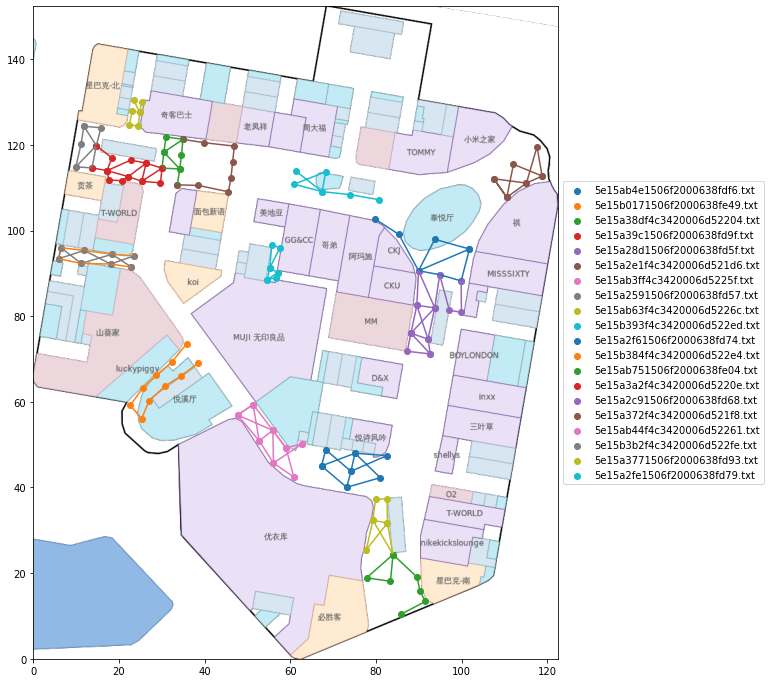

In [9]:
visualize_many_traces_on_the_map(
    traces_dataframes, MAP_IMAGE, MAP_WIDTH, MAP_HEIGHT, 
    traces_filenames=traces_filenames, 
    figsize=(15, 12)
)

# Features Visualization

Let's take a closer look at single trace (path) and its attributes.

In [10]:
filename='5e15b0171506f2000638fe49.txt'
trace_filepath = os.path.join(floor_train_dir, filename)

trace_df = load_trace_as_dataframe(trace_filepath)
trace_df

,time,type,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8
0,1578478950611,TYPE_WAYPOINT,35.81434,73.54972,NaN,NaN,NaN,NaN,NaN,NaN
1,1578478950696,TYPE_BEACON,d9c573b719a17da4836208fc436f87b5ca1aa877,b6589fc6ab0dc82cf12099d1c2d40ab994e8410c,b6589fc6ab0dc82cf12099d1c2d40ab994e8410c,-56.000000,-69.000000,4.609608,bbb0c3915a9608e1ae4a5029ce5ff32b422f4e52,1.578479e+12
2,1578478950733,TYPE_MAGNETIC_FIELD,16.067505,-35.10437,-14.152527,3.000000,NaN,NaN,NaN,NaN
3,1578478950733,TYPE_GYROSCOPE,-0.35499573,-0.35671997,-0.47543335,3.000000,NaN,NaN,NaN,NaN
4,1578478950733,TYPE_ROTATION_VECTOR,0.042973697,0.261133,0.92708725,3.000000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
28505,1578479005275,TYPE_GYROSCOPE,-0.014633179,0.017196655,0.0071258545,3.000000,NaN,NaN,NaN,NaN
28506,1578479005275,TYPE_ROTATION_VECTOR,0.21967757,-0.19740751,-0.594244,3.000000,NaN,NaN,NaN,NaN
28507,1578479005275,TYPE_MAGNETIC_FIELD_UNCALIBRATED,-39.54315,4.8568726,-363.15002,-2.886963,3.192139,-339.547730,3,NaN
28508,1578479005275,TYPE_GYROSCOPE_UNCALIBRATED,0.024963379,-0.018829346,-0.01637268,-0.009933,0.003937,-0.006989,3,NaN


Here is a table of the attributes we need to deal with in this competition. 

As you can see it contains feature names and its params. We will describe some of these features in more detail below.

Each feature can be extracted from trace as dataframe with params as columns. For this we are using function `extract_feature_df` which is suitable for all features except TYPE_WIFI and TYPE_BEACON.

The table is taken from [competition's official github repo](https://github.com/location-competition/indoor-location-competition-20). (I've slightly modified it just for a more compact view).

| Feature		                    | Values |       |        |        |                   |        |           |                                   |
|:----------------------------------|:------:|:-----:|:------:|:-------|:-----------------:|:------:|:---------:|:---------------------------------:|
|TYPE_WAYPOINT                      |X axis  |Y axis |       |         |                   |        |           |                                   |
|TYPE_ACCELEROMETER                 |X axis  |Y axis |Z axis |accuracy |                   |        |           |                                   |
|TYPE_GYROSCOPE                     |X axis  |Y axis |Z axis |accuracy |                   |        |           |                                   | 
|TYPE_MAGNETIC_FIELD                |X axis  |Y axis |Z axis |accuracy |                   |        |           |                                   | 
|TYPE_ROTATION_VECTOR               |X axis  |Y axis |Z axis |accuracy |                   |        |           |                                   |
|TYPE_ACCELEROMETER_UNCALIBRATED    |X axis  |Y axis |Z axis |X axis   |Y axis             |Z axis  |accuracy   |                                   |
|TYPE_GYROSCOPE_UNCALIBRATED        |X axis  |Y axis |Z axis |X axis   |Y axis             |Z axis  |accuracy   |                                   |
|TYPE_MAGNETIC_FIELD_UNCALIBRATED   |X axis  |Y axis |Z axis |X axis   |Y axis             |Z axis  |accuracy   |                                   |
|TYPE_WIFI                          |ssid    |bssid  |RSSI   |frequency|last seen timestamp|        |           |                                   |
|TYPE_BEACON                        |UUID    |MajorID|MinorID|Tx Power |RSSI               |Distance|MAC Address|same with Unix time, padding data  |


# TYPE_WAYPOINT

In [11]:
points_df = extract_feature_df(trace_df, 'TYPE_WAYPOINT', col_names=('x', 'y'))
points_df

,time,x,y
0,1578478950611,35.814340,73.549720
1,1578478957435,32.286610,69.241295
2,1578478963201,28.685219,66.200134
3,1578478967786,25.548065,63.200860
4,1578478972835,22.653585,59.197983
5,1578478982542,25.288015,56.029570
6,1578478991452,26.990536,60.162970
7,1578478996727,30.657862,63.585712
8,1578479000815,34.498150,66.055370
9,1578479004924,38.345330,68.955550


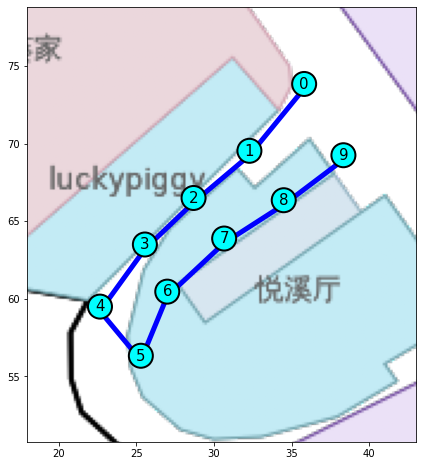

In [12]:
visualize_single_trace_on_the_map(
    points_df, MAP_IMAGE, MAP_WIDTH, MAP_HEIGHT, figsize=(10, 8)
)

# TYPE_ACCELEROMETER

In [13]:
acc_df = extract_feature_df(trace_df, 'TYPE_ACCELEROMETER')
acc_df

,time,x,y,z,accuracy
0,1578478950733,-0.334244,4.325256,7.615540,2.0
1,1578478950753,-0.505417,4.041534,7.962707,2.0
2,1578478950773,-0.967499,4.353989,8.285324,2.0
3,1578478950793,-1.474487,4.670013,8.069840,2.0
4,1578478950813,-1.438568,4.775970,7.264191,2.0
...,...,...,...,...,...
2700,1578479005194,-0.060104,4.756210,9.153213,2.0
2701,1578479005214,0.228394,4.910034,8.427170,2.0
2702,1578479005235,0.415741,4.879517,8.050690,2.0
2703,1578479005255,0.469009,4.956726,7.676590,2.0


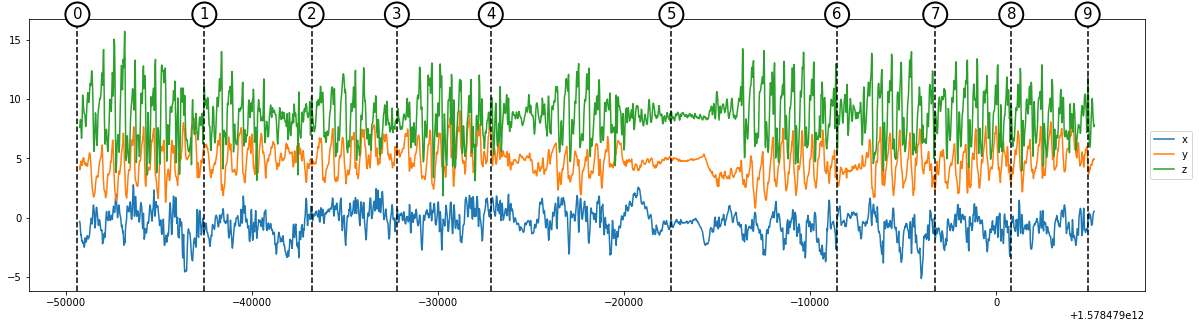

In [14]:
plot_trace_features(acc_df, points_df['time'], figsize=(20, 5))

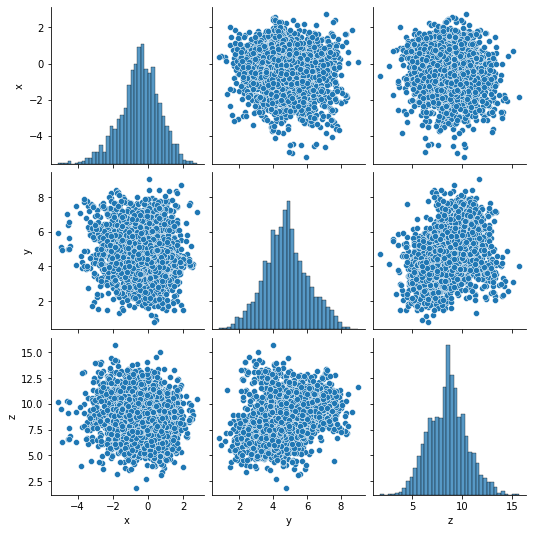

In [15]:
sns.pairplot(acc_df[['x', 'y', 'z']])
plt.show()

# TYPE_GYROSCOPE

In [16]:
gyro_df = extract_feature_df(trace_df, 'TYPE_GYROSCOPE')
gyro_df

,time,x,y,z,accuracy
0,1578478950733,-0.354996,-0.356720,-0.475433,3.0
1,1578478950753,-0.444473,-0.373230,-0.527634,3.0
2,1578478950773,-0.435944,-0.342331,-0.560654,3.0
3,1578478950793,-0.312378,-0.176163,-0.486084,3.0
4,1578478950813,-0.181351,0.065125,-0.377426,3.0
...,...,...,...,...,...
2700,1578479005194,-0.106247,-0.221436,0.048691,3.0
2701,1578479005214,-0.016769,-0.177765,-0.003525,3.0
2702,1578479005235,0.030640,-0.087204,-0.017899,3.0
2703,1578479005255,0.034897,-0.022766,-0.009384,3.0


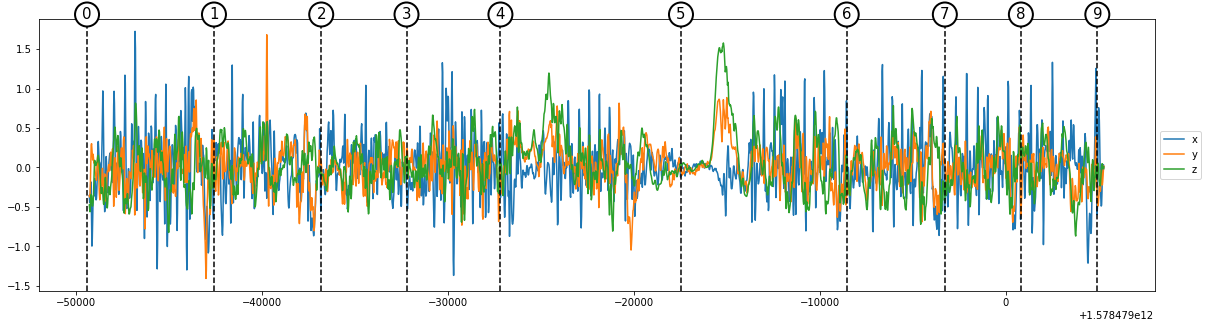

In [17]:
plot_trace_features(gyro_df, points_df['time'], figsize=(20, 5))

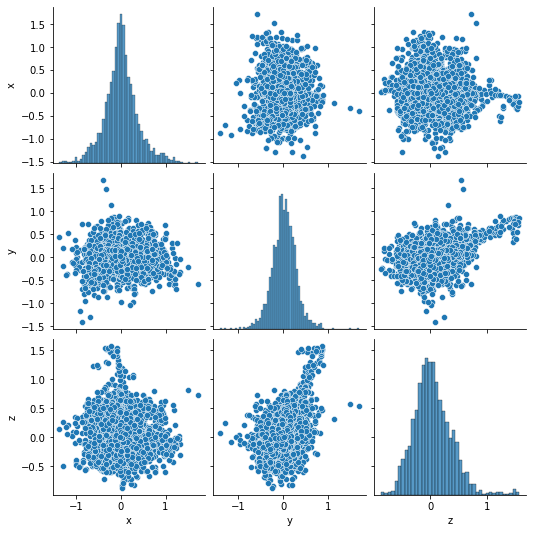

In [18]:
sns.pairplot(gyro_df[['x', 'y', 'z']])
plt.show()

# TYPE_MAGNETIC_FIELD

In [19]:
magn_df = extract_feature_df(trace_df, 'TYPE_MAGNETIC_FIELD')
magn_df

,time,x,y,z,accuracy
0,1578478950733,16.067505,-35.104370,-14.152527,3.0
1,1578478950753,15.374756,-37.185670,-14.826965,3.0
2,1578478950773,16.067505,-35.798645,-16.177368,3.0
3,1578478950793,18.148804,-36.491394,-16.177368,3.0
4,1578478950813,16.067505,-35.104370,-17.527771,3.0
...,...,...,...,...,...
2700,1578479005194,-38.044740,2.357483,-24.952698,3.0
2701,1578479005214,-36.656190,1.664734,-24.276733,3.0
2702,1578479005235,-36.656190,0.276184,-24.276733,3.0
2703,1578479005255,-35.963440,1.664734,-23.602295,3.0


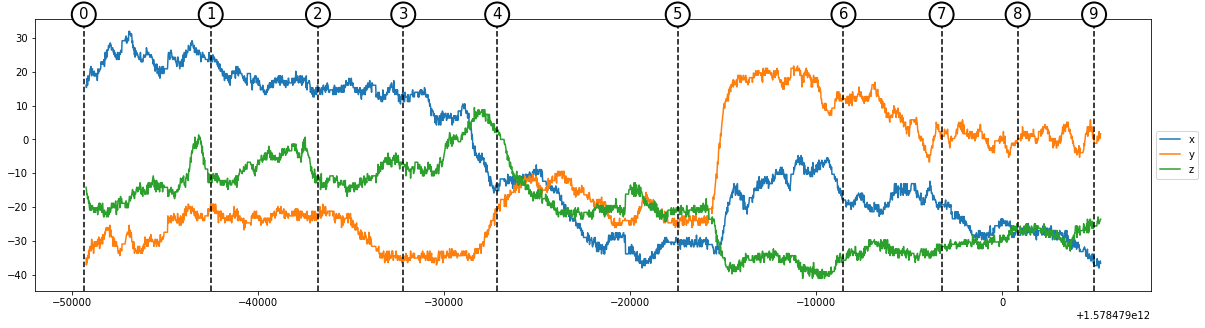

In [20]:
plot_trace_features(magn_df, points_df['time'], figsize=(20, 5))

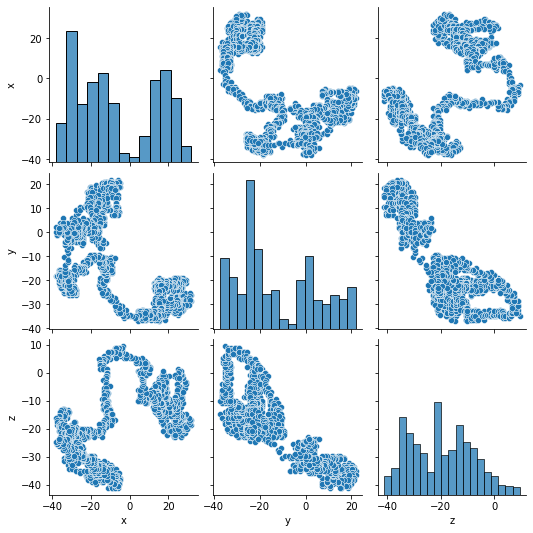

In [21]:
sns.pairplot(magn_df[['x', 'y', 'z']])
plt.show()

# TYPE_ROTATION_VECTOR

In [22]:
rot_df = extract_feature_df(trace_df, 'TYPE_ROTATION_VECTOR')
rot_df

,time,x,y,z,accuracy
0,1578478950733,0.042974,0.261133,0.927087,3.0
1,1578478950753,0.042974,0.261133,0.927087,3.0
2,1578478950773,0.036968,0.246351,0.929708,3.0
3,1578478950793,0.029699,0.247163,0.929281,3.0
4,1578478950813,0.029699,0.247163,0.929281,3.0
...,...,...,...,...,...
2700,1578479005194,0.220936,-0.195907,-0.595174,3.0
2701,1578479005214,0.219744,-0.196893,-0.595246,3.0
2702,1578479005235,0.219473,-0.197527,-0.595163,3.0
2703,1578479005255,0.219473,-0.197527,-0.595163,3.0


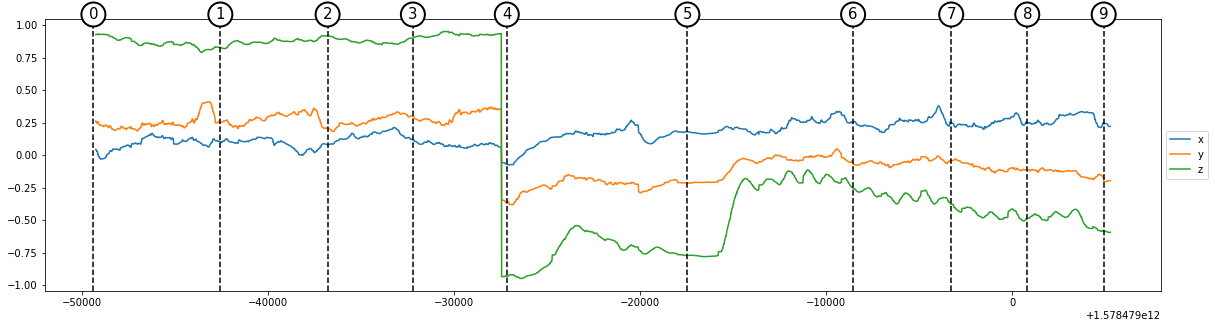

In [23]:
plot_trace_features(rot_df, points_df['time'], figsize=(20, 5))

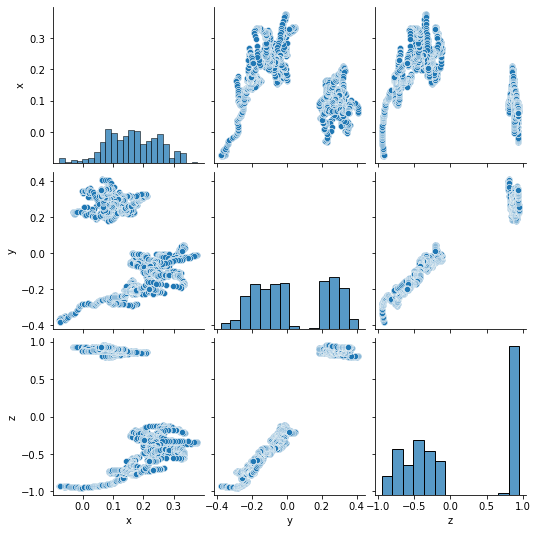

In [24]:
sns.pairplot(rot_df[['x', 'y', 'z']])
plt.show()

# References
* [Trace Parsing Script](https://www.kaggle.com/c/indoor-location-navigation/discussion/215381)
* [Competition's Github Repository](https://github.com/location-competition/indoor-location-competition-20)